### $\color{blue}{\textbf{CLASSIFICATION OF NIGHTTIME ACCIDENTS BASED ON NIGHTLIFE SPOTS IN THE AREA - Cpastone Project}}$

## $\color{blue}{\textbf{1 - Introduction / Business Problem}}$
The goal of this analysis is to assess, if there is a relationship between the number of late-night accidents and night life activities in the Toronto area. Usually, the bulk of the traffic is in the day when people are travelling to and from their work or they are going out to buy groceries, shopping etc. In general, the traffic is less in the night and less traffic should mean less traffic accidents.<br>

In this assignment I will analyze, if the number of night life spots in the Toronto area increases the number of accidents in the area at the nighttime or not. The accident data will be divided into daytime accidents and nighttime accidents, and I will focus on the nighttime accidents. The analysis will focus only on the business related to night life activities, like bars, pubs, night clubs etc.<br>

I will use Foursquare API to identify the number of nightlife spots in the Toronto area. The data for nightlife spots will be collected at the postal codes level. The accidents data will also be rolled up at the postal codes level.<br>

The nighttime activities are usually less during the weeknights, but they are comparatively more on the weekends. The analysis will compare the number of nighttime accidents during weeknights and weekend nights. A higher number of accidents at weekend nights in the areas with higher number of nightlife spots will indicate, nightlife spots may be a contributing factor of higher accidents in the area. <br>

The nightlife business like bars, night clubs, pubs, karaoke bars, etc. can use the analysis done in this project to take additional steps to ensure the safe returns of their customers. The accidents rate seems to be higher during weekend. Business especially over the weekend can offer deals which include vouchers for ride sharing services.  The businesses can work with the ride sharing or cab services to ensure easy availability of these services.  The area police can use the results to identify in which areas and what days of week the police need to increase the patrol. The health and safety departments of the highly affected neighborhoods can run public awareness campaigns.

## $\color{blue}{\textbf{2- Description of Data}}$
Data from four different data sources will be retrieved, cleaned, and merged using postal district as the common field among all the data.<br>

The accidents data will be retrieved from the Toronto [open data source portal](https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/6719b900-1bf9-4678-b9a0-547e30a24846?format=csv&projection=4326). The data includes accidents data from 2006 till the end of 2019. The accident data is before the start of covid pandemic, so no impact of mandatory closing of businesses due to covid. The data includes the exact time when the accident happened, the location of accident, etc. Accident details are available for more than 16000 accidents over a period of 14 years.<br> 

The [postal districts data] (https://cocl.us/Geospatial_data) with the longitude and latitude is available on the internet. The postal districts will be used to define regions in the Toronto city. The analysis will collect and summarize the data at the postal district level.<br>

Toronto's neighborhood and Borough's data is retrieved from the [WIKIPEDIA  page] (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). This data will allow us to see results at the Borough's level.<br>

FOURSQUARE has the data on all the night life venues organized under categories and subcategories. All the night life venues can be found under one main category using the API. The FOURSQUARE API will be used to search the businesses under the category ‘Nightlife Spot’ in each of Toronto’s postal district. <br>

Data from all the four data sources will be combined and summarized at the postal district level.


In [1]:
# Importing all the required libraries
%matplotlib inline 
import warnings

import pandas as pd
import numpy as np
import datetime
import calendar

import folium # required to draw the map
from folium import plugins

import requests# required to process the FourSquare requests
from pandas.io.json import json_normalize # required to process foursquare response

from sklearn.cluster import DBSCAN # 
from sklearn.cluster import KMeans
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

import html5lib
import lxml
from bs4 import BeautifulSoup


import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from tqdm.auto import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

from scipy.spatial.distance import cdist

from IPython import display
from base64 import b64decode
from PIL import Image

print('Libraries imported.')


Libraries imported.
<ipython-input-1-d530cf9486fc>:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# no warnings will be printed from now on
warnings.filterwarnings(action='ignore')
mpl.style.use('fivethirtyeight') # setting the stule for graphs #
labCol='blue'

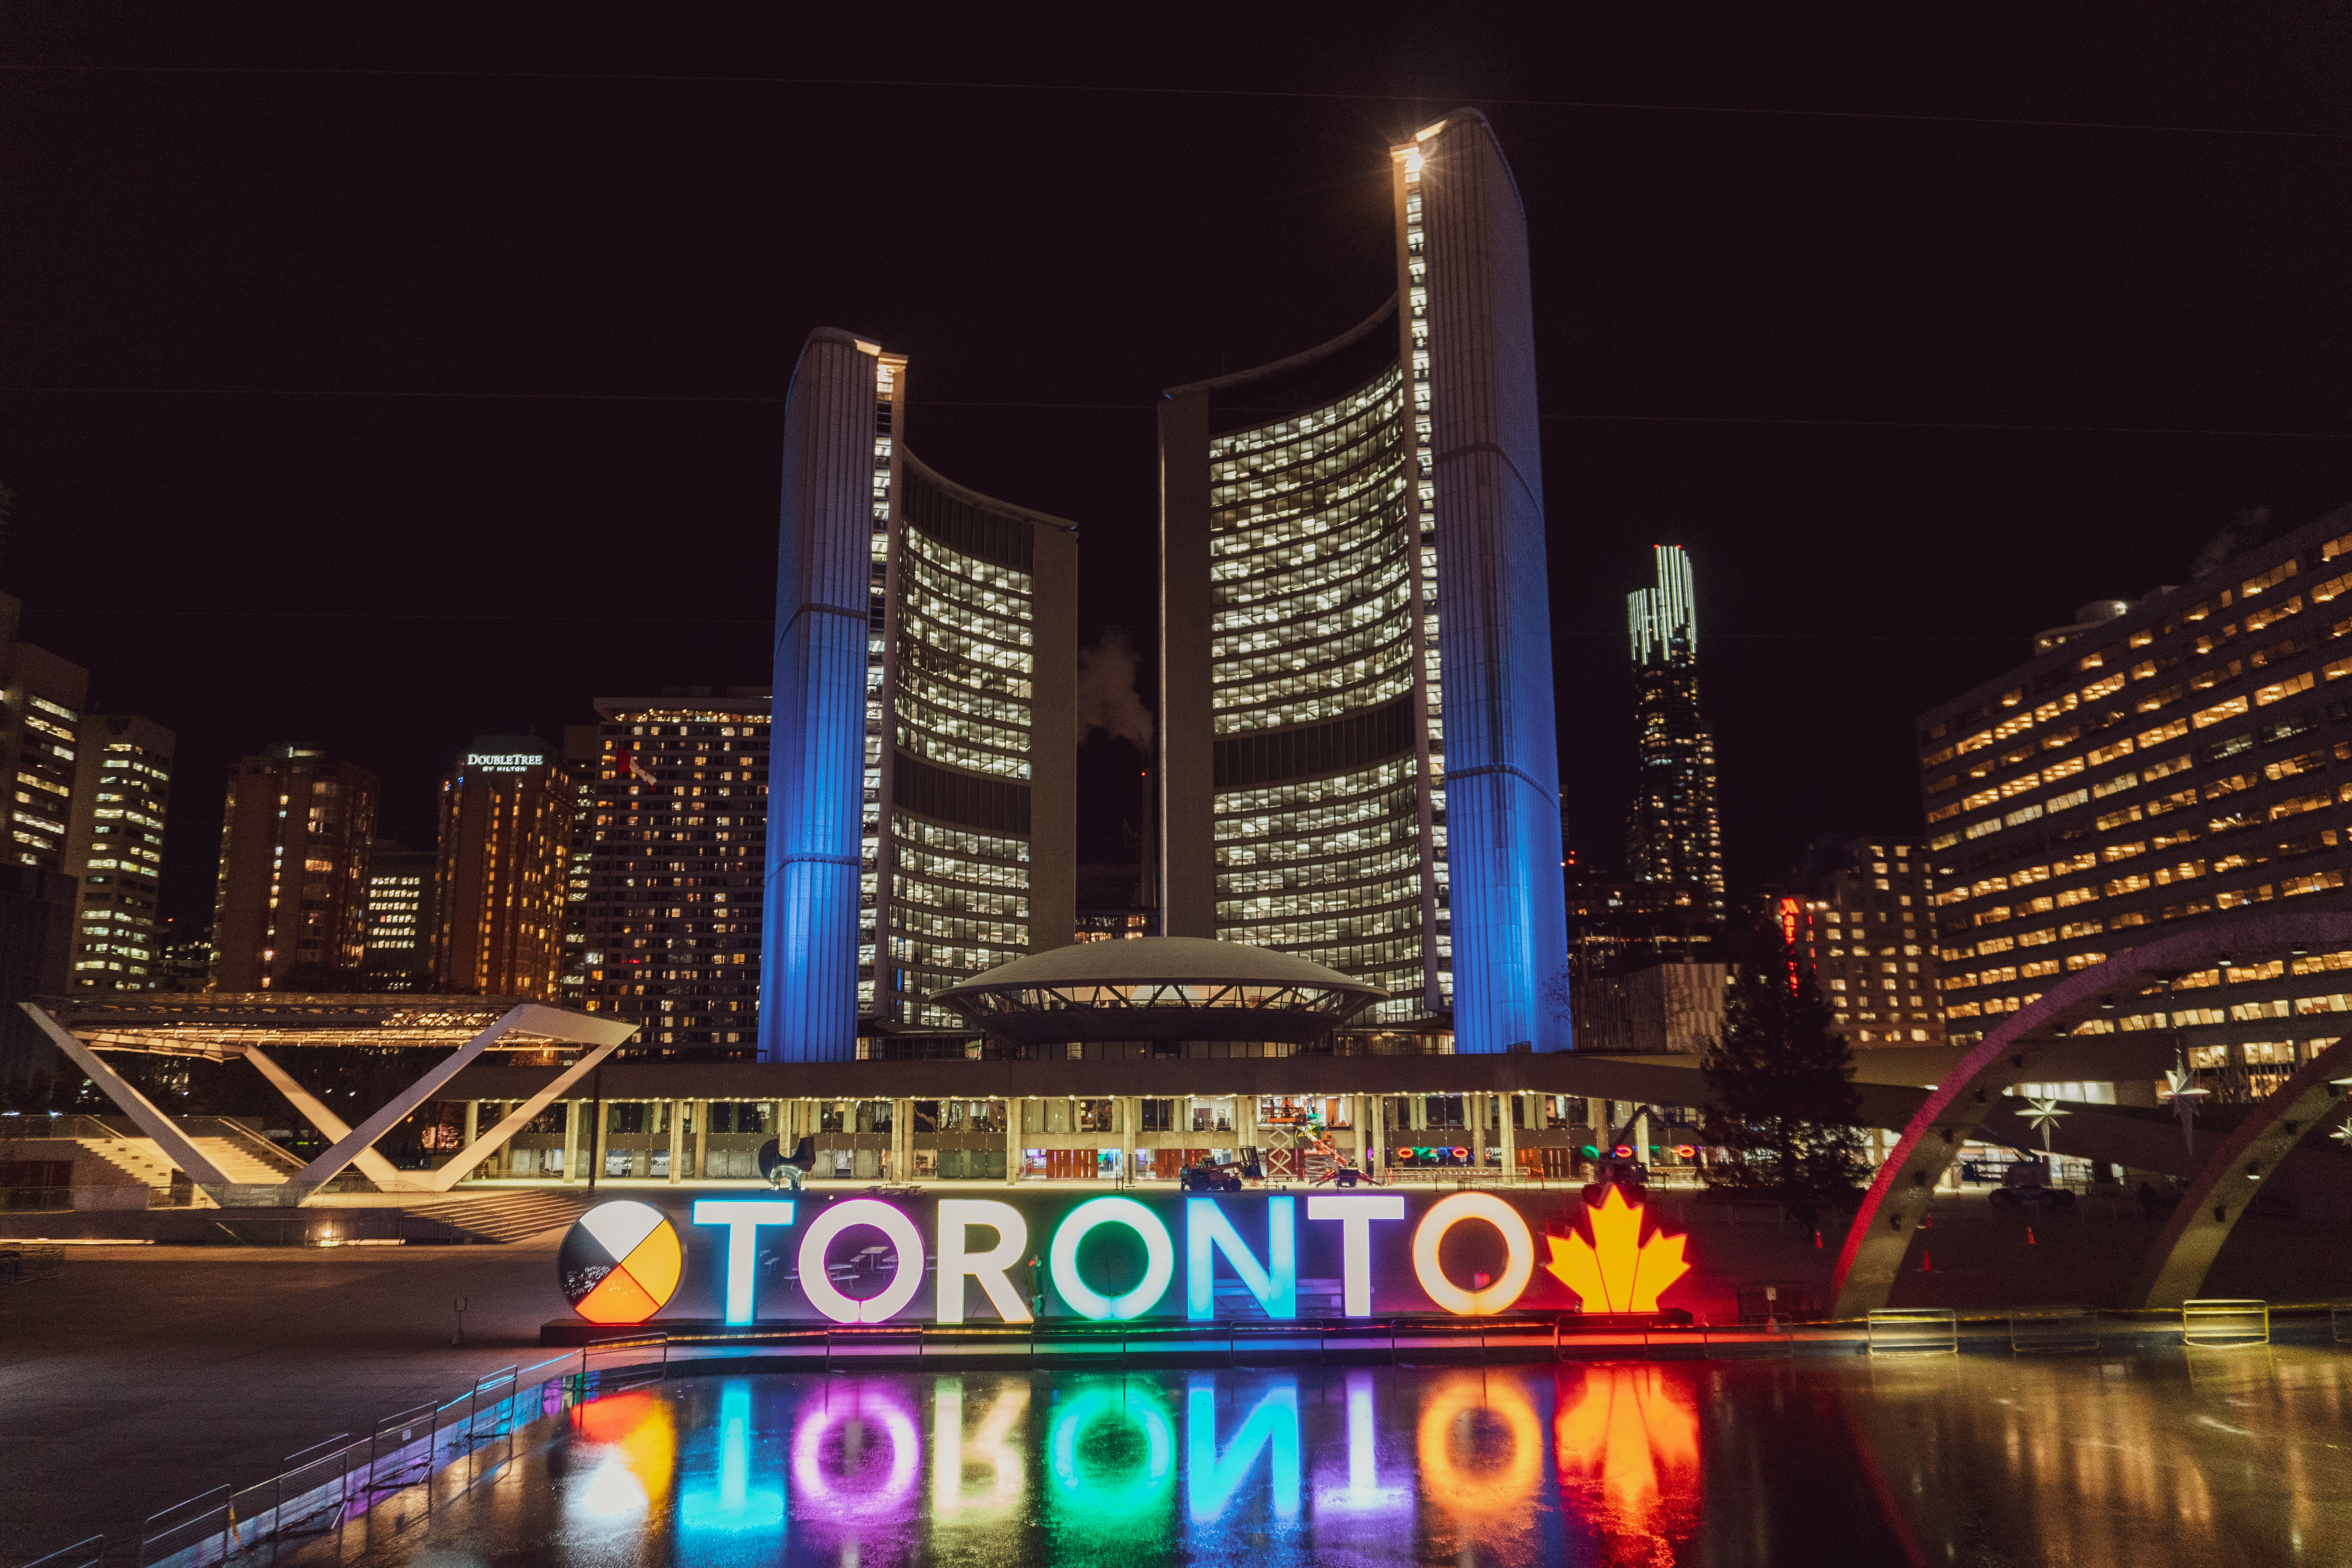

In [3]:
display.Image(filename = "./images/Toronto Night -01.jpg")

## $\color{blue}{\textbf{3 - Data Acquisition and Data Cleanup}}$ <br>
Data from four different sources will be loaded and cleaned up. <br>
The data sources are as follow<br><br>
<strong> 1 - Accident Data </strong> Serious Accident data for Toronto area.<br>
<strong> 2 - Postal Districts </strong> Toronto city postal districts with their geo coordinates. <br>
<strong> 3 - Toronto Boroughs & Neighbourhoods </strong> Borough's and neighbourhood data for the city of Toronto <br> 
<strong> 4 - Nightlife Spots (venue data) </strong> Venues from foursqaure API categorized as Nightlife spots.

### $\color{blue}{\textbf{3.1 - Accident Data}}$ <br>
Serious Accident data starting from 2006 to 2019 for the city of Toronto. <br> The data provides all the details related to accident like location of accident, date & time of accident,etc. 
<br>  The data is available at Toronto's open data portal.<br>


In [4]:
## loading serious accidents data. 
accident_df=pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/6719b900-1bf9-4678-b9a0-547e30a24846?format=csv&projection=4326')
accident_df.head()

_id  ACCNUM  YEAR                 DATE  TIME  HOUR          STREET1  \
0    1  892658  2006  2006-03-11T00:00:00   852     8       BLOOR ST W   
1    2  892658  2006  2006-03-11T00:00:00   852     8       BLOOR ST W   
2    3  892810  2006  2006-03-11T00:00:00   915     9  MORNINGSIDE AVE   
3    4  892810  2006  2006-03-11T00:00:00   915     9  MORNINGSIDE AVE   
4    5  892682  2006  2006-03-12T00:00:00   240     2   EGLINTON AVE E   

            STREET2 OFFSET      ROAD_CLASS  ... SPEEDING AG_DRIV REDLIGHT  \
0       DUNDAS ST W    NaN  Major Arterial  ...      NaN     Yes      NaN   
1       DUNDAS ST W    NaN  Major Arterial  ...      NaN     Yes      NaN   
2    SHEPPARD AVE E    NaN  Major Arterial  ...      NaN     Yes      Yes   
3    SHEPPARD AVE E    NaN  Major Arterial  ...      NaN     Yes      Yes   
4  COMMONWEALTH AVE    NaN  Major Arterial  ...      NaN     NaN      NaN   

  ALCOHOL DISABILITY POLICE_DIVISION HOOD_ID         NEIGHBOURHOOD ObjectId  \
0     NaN        NaN             D11      88  High Park North (88)        1   
1     NaN        NaN             D11      88  High Park North (88)        2   
2     NaN        NaN             D42     131           Rouge (131)        3   
3     NaN        NaN             D42     131           Rouge (131)        4   
4     Yes        NaN             D41     138   Eglinton East (138)        5   

                                            geometry  
0  {u'type': u'Point', u'coordinates': (-79.45249...  
1  {u'type': u'Point', u'coordinates': (-79.45249...  
2  {u'type': u'Point', u'coordinates': (-79.19978...  
3  {u'type': u'Point', u'coordinates': (-79.19978...  
4  {u'type': u'Point', u'coordinates': (-79.25619...  

[5 rows x 54 columns]

In [5]:
print('Total {} number of serious accidents records loaded'.format(accident_df.shape[0]))

Total 16860 number of serious accidents records loaded


In [6]:
# Filter the data frame for the columns required for analysis
accident_df = accident_df[['ACCNUM','YEAR','DATE','HOUR','DISTRICT','NEIGHBOURHOOD','geometry'  ]]
# dropping the accident for 2020 & 2021 as it may get impacted by covide restrictions
accident_df.drop(accident_df[accident_df['YEAR']>2019].index,inplace=True) 
# dropping the rows which contains a null value for one or more columns
accident_df.dropna(inplace=True)

In [7]:
# setting the gelocator. gelocator will be used to find the postal district of accident from geo coordinates.
geolocator = Nominatim(user_agent="toronto FSA")
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [8]:
# function finds the postal disctrict using the geometry in the accident row
def findFSA(row):
    ts = row['geometry'].rsplit(':')[2]
    ts = ts.replace('(','').replace(')','').replace('}','')
    ts = ts.split(',')

    location = reverse((float(ts[1]),float(ts[0])), language='en', exactly_one=True)
    location = location.raw['address']['postcode']
    
    return (location[0:3])

In [9]:
# Adding new columns in the frame and initialzing them.
accident_df['nightTime']=-1
accident_df['lat']=-1.0
accident_df['long']=-1.0
accident_df['FSA']=''
accident_df['wDay']=''
accident_df['weekend']=-1
cList =accident_df.columns.to_list()

In [10]:
# Time of accident is in 24 hours format. 
# Dividing the accident either into daytime or late night categories 

dayHour = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # Accident from 5 Am till 8 PM will be counted in the daytime
nightHour= [21,22,23,0,1,2,3,4] # Accidents from 9 PM to 4 AM in the morning will be counted in the nighTime

for r in range(len(accident_df)):  
    
    # setting nightTime column to 1 if its in nightHour else 0
    if accident_df.iloc[r,cList.index('HOUR')] in nightHour:
        accident_df.iat[r,cList.index('nightTime')]=1
    else:
        accident_df.iat[r,cList.index('nightTime')]=0

    # seperating the latitude and longitude and storing in the columns
    ts = accident_df.iloc[r,cList.index('geometry')].rsplit(':')[2]
    ts = ts.replace('(','').replace(')','').replace('}','')
    ts = ts.split(',')
    accident_df.iat[r,cList.index('lat')]=float(ts[1])
    accident_df.iat[r,cList.index('long')]=float(ts[0])
    
    # Find Day of the week for accident
    dy = accident_df.iloc[r,cList.index('DATE')].split('T')[0]
    dy = datetime.datetime.strptime(dy,'%Y-%m-%d').weekday()
    dy= calendar.day_name[dy]
    accident_df.iat[r,cList.index('wDay')]=dy[0:3]

    # Setting weekend col to 1 for 3 day weekend and 0 for all other days
    weekendDays =['Fri','Sat','Sun']
    if accident_df.iloc[r,cList.index('wDay')] in weekendDays:
        accident_df.iat[r,cList.index('weekend')]= 1
    else:
        accident_df.iat[r,cList.index('weekend')]= 0
        
    # Neighbourhood , and Neighbourhood ID
    s1=accident_df.iloc[r,cList.index('NEIGHBOURHOOD')].split('(')
    accident_df.iat[r,cList.index('NEIGHBOURHOOD')]=s1[0].strip()


In [11]:
print('Total number of night time accidents are {} and daytime accidents are {}'.format(len(accident_df[accident_df['nightTime'] == 1]),len(accident_df[accident_df['nightTime'] == 0])))

Total number of night time accidents are 3961 and daytime accidents are 12229


In [12]:
# creating a dataframe containing only the nightTime Accidents
nightAccident_df = accident_df[accident_df['nightTime'] == 1]
nightAccident_df.head()

ACCNUM  YEAR                 DATE  HOUR     DISTRICT    NEIGHBOURHOOD  \
4   892682  2006  2006-03-12T00:00:00     2  Scarborough    Eglinton East   
5   892682  2006  2006-03-12T00:00:00     2  Scarborough    Eglinton East   
6   892682  2006  2006-03-12T00:00:00     2  Scarborough    Eglinton East   
26  893720  2006  2006-03-18T01:00:00     3   North York  Willowdale East   
27  893720  2006  2006-03-18T01:00:00     3   North York  Willowdale East   

                                             geometry  nightTime        lat  \
4   {u'type': u'Point', u'coordinates': (-79.25619...          1  43.734945   
5   {u'type': u'Point', u'coordinates': (-79.25619...          1  43.734945   
6   {u'type': u'Point', u'coordinates': (-79.25619...          1  43.734945   
26  {u'type': u'Point', u'coordinates': (-79.40429...          1  43.774945   
27  {u'type': u'Point', u'coordinates': (-79.40429...          1  43.774945   

        long FSA wDay  weekend  
4  -79.25619      Sun        1  
5  -79.25619      Sun        1  
6  -79.25619      Sun        1  
26 -79.40429      Sat        1  
27 -79.40429      Sat        1

In [13]:
tqdm_notebook.pandas()
nightAccident_df['FSA']=nightAccident_df.progress_apply(findFSA,axis=1)
nightAccident_df =nightAccident_df[nightAccident_df['FSA'].str[0]=='M']# filtering for toronto FSA
nightAccident_df.head() 

  0%|          | 0/3961 [00:00<?, ?it/s]

ACCNUM  YEAR                 DATE  HOUR     DISTRICT    NEIGHBOURHOOD  \
4   892682  2006  2006-03-12T00:00:00     2  Scarborough    Eglinton East   
5   892682  2006  2006-03-12T00:00:00     2  Scarborough    Eglinton East   
6   892682  2006  2006-03-12T00:00:00     2  Scarborough    Eglinton East   
26  893720  2006  2006-03-18T01:00:00     3   North York  Willowdale East   
27  893720  2006  2006-03-18T01:00:00     3   North York  Willowdale East   

                                             geometry  nightTime        lat  \
4   {u'type': u'Point', u'coordinates': (-79.25619...          1  43.734945   
5   {u'type': u'Point', u'coordinates': (-79.25619...          1  43.734945   
6   {u'type': u'Point', u'coordinates': (-79.25619...          1  43.734945   
26  {u'type': u'Point', u'coordinates': (-79.40429...          1  43.774945   
27  {u'type': u'Point', u'coordinates': (-79.40429...          1  43.774945   

        long  FSA wDay  weekend  
4  -79.25619  M1K  Sun        1  
5  -79.25619  M1K  Sun        1  
6  -79.25619  M1K  Sun        1  
26 -79.40429  M2N  Sat        1  
27 -79.40429  M2N  Sat        1

In [14]:
nightAccidentSummary_df =nightAccident_df.groupby(['FSA']).agg(
    totalAccidents=('ACCNUM','count'), # Total number of night time accident in the FSA
    accidentWeekend=('weekend','sum') # sum of weekend accidents, weekend is 1 non weekend is 0
    )
# calculating the night time Week days accidents from the total accidents minus weekend accidents
nightAccidentSummary_df['accidentWeekDays'] = nightAccidentSummary_df['totalAccidents'] - nightAccidentSummary_df['accidentWeekend'] 

nightAccidentSummary_df.reset_index(inplace=True)
nightAccidentSummary_df.head()



FSA  totalAccidents  accidentWeekend  accidentWeekDays
0  M1B              99               42                57
1  M1C              34               22                12
2  M1E              43               21                22
3  M1G              11                8                 3
4  M1H              80               70                10

### $\color{blue}{\textbf{3.2 - Postal Districts}}$ <br>
Read Postal Codes for Toronto along with their longitude and latitude from the [external file](https://cocl.us/Geospatial_data). <br>
The file contains longitude and latitude for the postal codes, based on FSA (Forward Sortation Area).<br>
FSA is a way to designate a geographical unit based on the first three characters in a Candian postal code.

In [15]:
postal_df = pd.read_csv('https://cocl.us/Geospatial_data')
# rename the 'Postal Code' column from the file to FSA.
postal_df.rename(columns={'Postal Code':'FSA'},inplace=True)
print('Total number of  Forward Sortation Areas (postal code) or georphical units in Toronto are {}'.format(postal_df.shape[0]))

Total number of  Forward Sortation Areas (postal code) or georphical units in Toronto are 103


In [16]:
postal_df.head()

FSA   Latitude  Longitude
0  M1B  43.806686 -79.194353
1  M1C  43.784535 -79.160497
2  M1E  43.763573 -79.188711
3  M1G  43.770992 -79.216917
4  M1H  43.773136 -79.239476

### $\color{blue}{\textbf{3.3 - Toronto Boroughs & Neighbourhoods}}$
Retrieve Toronto's distribution of postal codes , neighbourhoods by the boroughs.
![Toronto Neighbourhoods Boroughs](./images/TorontoNeighborhoods.png)

In [17]:
# Scrapping the information from the wikipedia page
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r=requests.get(url)
soup=BeautifulSoup(r.content,'html5lib') 
# Processing the table data rerieved from the wikipedia page
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# Creating Borough's and Neighbourhood dataframe from the data retrieved from wikipedia page
borough_df=pd.DataFrame(table_contents)
borough_df['Borough']=borough_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto',
                                             'EtobicokeNorthwest':'Etobicoke','East YorkEast Toronto':'East York',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
borough_df.drop(borough_df[(borough_df.PostalCode =='M7R') | (borough_df.PostalCode =='M7A')].index, inplace=True)
borough_df.rename(columns={'PostalCode':'FSA'},inplace=True)
borough_df.head()

FSA           Borough                      Neighborhood
0  M3A        North York                         Parkwoods
1  M4A        North York                  Victoria Village
2  M5A  Downtown Toronto         Regent Park, Harbourfront
3  M6A        North York  Lawrence Manor, Lawrence Heights
5  M9A         Etobicoke                  Islington Avenue

### $\color{blue}{\textbf{3.4 - Nightlife Spots (venue data)}}$ <br>
Retrieving venues using Foursquare API for the Toronto postal codes. <br>
Retrieving data only for venues which fall under the Nightlife Spot main venue category.

In [18]:
# Defining constants for the venue categories
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
ACCESS_TOKEN = # your access token

VERSION = '20190425' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
RADIUS = 1500 # define radius in meters
NIGHTLIFE_CATEGORYID = '4d4b7105d754a06376d81259' #  Nightlife spot category

In [20]:
def getVenuesInPostal(lat,lon,CATEGORYID):
# create URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID,     CLIENT_SECRET,     ACCESS_TOKEN,     VERSION,     lat,     lon,     CATEGORYID,    RADIUS,     LIMIT
    )
    
    results = requests.get(url).json() # Load JSON
        
    # assign relevant part of JSON to venues
    ven = results['response']['venues']

    # tranform venues into a dataframe
    ven_df = json_normalize(ven)
        
    return ven_df


In [21]:
def venueFSA(row):
    if (row['location.postalCode'].startswith('M') and len(row['location.postalCode']) >=3):
        return(row['location.postalCode'][0:3])
    else:
        return(row['FSA'])


In [22]:
## loop through all the FSA codes
## Identify  venues categorized as nightlife spots using the function getVenuesInPostal

for ind in postal_df.index:
  
    # retrieve venues in the given postal (FSA) using geocordinates for Nighlife spots
    tmpDF= getVenuesInPostal(postal_df.iloc[ind]['Latitude'],postal_df.iloc[ind]['Longitude'],NIGHTLIFE_CATEGORYID)
    if (len(tmpDF)==0): # postalcode without any venue
        continue
    
    tmpDF.reset_index(inplace=True)
    
    # add columns for mainCategory and FSA in tmpDF and initialize.
    tmpDF['mainCat'] = 'Nightlife Spot' 
    # First assign the postal code used to make the call
    tmpDF['FSA'] =postal_df.iloc[ind]['FSA']

    # if postalcode col missing
    if (tmpDF.columns.tolist().count('location.postalCode')==0):
        tmpDF['location.postalCode'] = postal_df.iloc[ind]['FSA']
    else: # replacing null or nan with calling postal code as default
        tmpDF['location.postalCode']=tmpDF['location.postalCode'].fillna(postal_df.iloc[ind]['FSA'])

    tmpDF['location.postalCode']=tmpDF['location.postalCode'].str.upper()
    tmpDF['FSA'] =tmpDF.apply(venueFSA,axis=1)
    
    # Add or append the Nightlife Spot venues returned into the main venues frame
    if (ind == 0):
        venues_df = tmpDF     
    else:
        venues_df=venues_df.append(tmpDF)
    


In [23]:
venues_df.reset_index(inplace=True) # reset the venues_df index
# Identify unique venues, before removing duplicate venues
print('Unique Nightlife spot venues are {}, before removing duplicates and total venues retrived are {}'.format(len(pd.unique(venues_df['id'])),venues_df.shape[0])) 

Unique Nightlife spot venues are 1378, before removing duplicates and total venues retrived are 2850


In [24]:
# sorting based on first venue id second distance from the given FSA
venues_df=venues_df.sort_values(['id','location.distance'])

# dropping the duplicate venue records based on venue id , location distance from given FSA lat , long
# Keep the venue with less distance, they are closer to the center of given FSA
venues_df=venues_df.drop_duplicates(subset='id',keep='first')
venues_df=venues_df.sort_values(['FSA','location.distance']) # sorting back on postal code first and then distance

venues_df=venues_df[['id', 'name','categories','FSA','location.lat','location.lng']]
venues_df.dropna(inplace=True) # drop any row with missing data
venues_df.reset_index(inplace=True) # reset the venues_df index
venues_df.head()


index                        id               name  \
0      0  58c4bd8f9b7eac1809c5e138    Tropical Nights   
1      3  4fbfe4dfe4b01f4bd18515e8        The dungeon   
2      5  4b10352df964a520556b23e3       Boston Pizza   
3      4  50df9a42498e2bcb1e11dc08  Having some beers   
4      2  50dfa65fe4b0748c74b49058        LTB is Here   

                                          categories  FSA  location.lat  \
0  [{'id': '4bf58dd8d48988d121941735', 'name': 'L...  M1B     43.800955   
1  [{'id': '4bf58dd8d48988d1d8941735', 'name': 'G...  M1B     43.810576   
2  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...  M1B     43.796470   
3  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...  M1B     43.796317   
4  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...  M1B     43.796366   

   location.lng  
0    -79.200427  
1    -79.207101  
2    -79.204245  
3    -79.204297  
4    -79.204424

In [25]:
# function that extracts the sub category of the venue. 
def get_subCategory_type(row):
    
    try:
        categories_list = row['categories']
    except:
        categories_list = ['']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
# Identify the sub category for each row 
venues_df['subCat'] = venues_df.progress_apply(get_subCategory_type, axis=1) # Passing all the rows to the function
print('Unique Nightlife spot venues are {}'.format(venues_df.shape[0])) 
venues_df.head()

  0%|          | 0/1378 [00:00<?, ?it/s]

Unique Nightlife spot venues are 1378


index                        id               name  \
0      0  58c4bd8f9b7eac1809c5e138    Tropical Nights   
1      3  4fbfe4dfe4b01f4bd18515e8        The dungeon   
2      5  4b10352df964a520556b23e3       Boston Pizza   
3      4  50df9a42498e2bcb1e11dc08  Having some beers   
4      2  50dfa65fe4b0748c74b49058        LTB is Here   

                                          categories  FSA  location.lat  \
0  [{'id': '4bf58dd8d48988d121941735', 'name': 'L...  M1B     43.800955   
1  [{'id': '4bf58dd8d48988d1d8941735', 'name': 'G...  M1B     43.810576   
2  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...  M1B     43.796470   
3  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...  M1B     43.796317   
4  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...  M1B     43.796366   

   location.lng       subCat  
0    -79.200427       Lounge  
1    -79.207101      Gay Bar  
2    -79.204245  Pizza Place  
3    -79.204297          Bar  
4    -79.204424          Bar

In [27]:
# count the nightlife spot venues by the postal district
venuesSummary_df=pd.DataFrame(venues_df['FSA'].value_counts())
venuesSummary_df.reset_index(inplace=True)
venuesSummary_df.rename(columns={'FSA':'nightVenueCount'},inplace=True)
venuesSummary_df.rename(columns={'index':'FSA'},inplace=True)

venuesSummary_df.head()

FSA  nightVenueCount
0  M5V               54
1  M6H               42
2  M2N               42
3  M4M               37
4  M3J               34

### $\color{blue}{\textbf{3.5 -Combine Data}}$
The data retrieved from all four sources (night accidents, postal codes, Boroughs & Neighbourhoods, and venues) will be merge into one data frame by the postal code (FSA)


In [28]:
combine_df = pd.merge(nightAccidentSummary_df,venuesSummary_df,on='FSA')

combine_df = pd.merge(combine_df,postal_df, on='FSA')
combine_df = pd.merge(combine_df,borough_df, on='FSA')

combine_df.sort_values(by=['nightVenueCount'],ascending=False,inplace=True)
combine_df.head()

FSA  totalAccidents  accidentWeekend  accidentWeekDays  nightVenueCount  \
65  M5V             147               94                53               54   
71  M6H             115               70                45               42   
21  M2N              94               59                35               42   
42  M4M              98               52                46               37   
28  M3J              47               23                24               34   

     Latitude  Longitude           Borough  \
65  43.628947 -79.394420  Downtown Toronto   
71  43.669005 -79.442259      West Toronto   
21  43.770120 -79.408493        North York   
42  43.659526 -79.340923      East Toronto   
28  43.767980 -79.487262        North York   

                                         Neighborhood  
65  CN Tower, King and Spadina, Railway Lands, Har...  
71                       Dufferin, Dovercourt Village  
21                                   Willowdale South  
42                                    Studio District  
28                    Northwood Park, York University

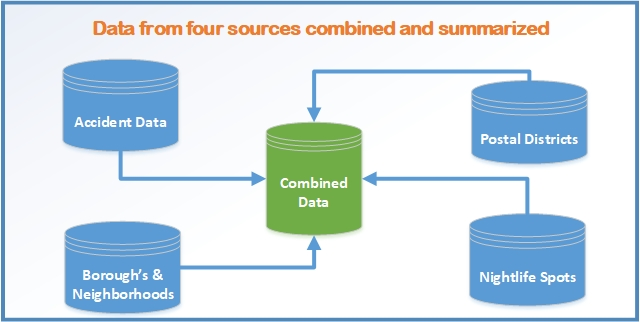

In [29]:

# image showing data from 4 different data sources is combined into 1 dataframe
display.Image(filename = "./images/merge_data.jpg")


##  $\color{blue}{\textbf{4 - Exploratory Data Analysis}}$ <br>
This section will explore the trends or patterns any present in the data.

In [30]:
#preparing data set to show comparisions of accidents during the week
dq =accident_df.groupby(['wDay']).agg(
    totalAccidents=('ACCNUM','count'), # Total number of night time accident in the FSA
    nightAccidents=('nightTime','sum') # sum of weekend accidents, weekend is 1 non weekend is 0
    )

dq.reset_index(inplace=True)

dq['dayAccidents']=dq['totalAccidents'] - dq['nightAccidents']
dq['wIndex'] = dq.wDay.map({'Mon':1,'Tue':2,'Wed':3,'Thu':4,'Fri':5,'Sat':6,'Sun':7})
dq.sort_values(by=['wIndex'],inplace=True)
dq.head(7)

wDay  totalAccidents  nightAccidents  dayAccidents  wIndex
1  Mon            2182             412          1770       1
5  Tue            2374             424          1950       2
6  Wed            2343             409          1934       3
4  Thu            2252             489          1763       4
0  Fri            2628             595          2033       5
2  Sat            2201             809          1392       6
3  Sun            2210             823          1387       7

### $\color{blue}{\textbf{4.1 - Day time Accidents vs Night time Accidents}}$<br>
Comparisions of Day and Night time accidents during the whole week.
Is there a pattern exists ?

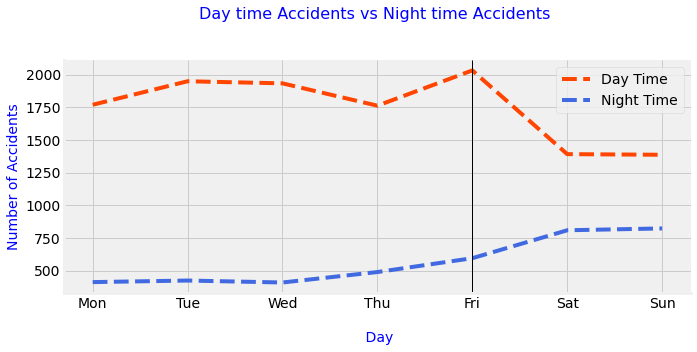

In [31]:
# Graph showing the comparision of accidents during week

labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
x=np.arange(len(labels))

fig = plt.figure(figsize=(10,4),frameon=False) #frameon If False, suppress drawing the figure background patch.
ax = fig.add_subplot(111)

ax.spines["right"].set_visible(False)# border lines of the figure, except bottom one hiding the 3 others 
ax.spines["top"].set_visible(False)

# column list is names of df converted into a list above
ax.plot(dq['wDay'],dq['dayAccidents'],linewidth=4.0, color='orangered',linestyle='dashed', label='Day Time')
ax.plot(dq['wDay'],dq['nightAccidents'],linewidth=4.0, color='royalblue',linestyle='dashed', label='Night Time')

ax.xaxis.set_label_position('top')
ax.set_title("Day time Accidents vs Night time Accidents \n \n ", fontsize=16, color=labCol)
ax.set_xticks(x)
ax.set_xticklabels(labels,  fontsize=14) #rotation=90,
ax.set_ylabel('Number of Accidents', color=labCol,fontsize=14)

ax.xaxis.set_label_position('bottom')
ax.set_xlabel('\n Day',fontsize=14, color=labCol)
ax.legend(loc='upper right')
plt.axvline(x=4,linewidth=1, color='black')

plt.show()

#### Starting from Friday, daytime accidents dropped and nighttime accidents went up.<br> Daytime accidents are expected to drop over the weekend but nighttime accidents going up <br> indicate nighttime activities are contributing for higher rate of accidents on weekend nights.

### $\color{blue}{\textbf{4.2 - Accidents in Postal Districts with highest number of Nightlife Spots}}$
Evaluate the trends of accidents in the top 10 postal districts by the number of nightlife spots.<br>
Is there a relationship between the number of nightlife spots and accidents on weekend nights ? 


In [32]:
top10 = venuesSummary_df.head(10)
top10 = pd.merge(top10,nightAccidentSummary_df,  on='FSA')
top10.head()

FSA  nightVenueCount  totalAccidents  accidentWeekend  accidentWeekDays
0  M5V               54             147               94                53
1  M6H               42             115               70                45
2  M2N               42              94               59                35
3  M4M               37              98               52                46
4  M3J               34              47               23                24

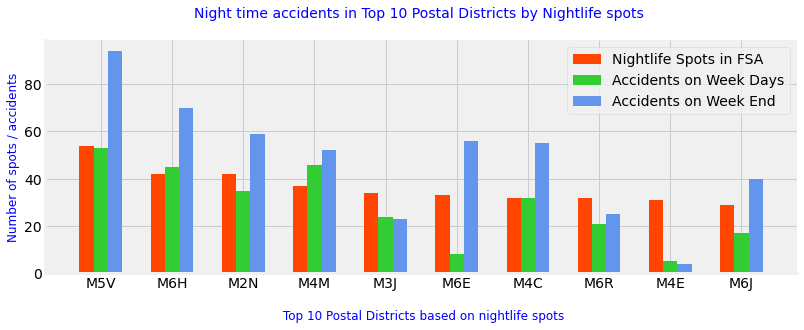

In [33]:
labels = top10.FSA.to_list()
x=np.arange(len(labels))
width = 0.2
fig = plt.figure(figsize=(12,4),frameon=False) #frameon If False, suppress drawing the figure background patch.
ax = fig.add_subplot(111)

ax.spines["right"].set_visible(False)# border lines of the figure, except bottom one hiding the 3 others 
ax.spines["top"].set_visible(False)

# column list is names of df converted into a list above
ax.bar(x-width,top10['nightVenueCount'], width, color='orangered'  , label='Nightlife Spots in FSA') # column list is names of df converted into a list above
ax.bar(x,top10['accidentWeekDays'],width, color='limegreen', label='Accidents on Week Days')
ax.bar(x+width,top10['accidentWeekend'],width, color='cornflowerblue', label='Accidents on Week End')


ax.xaxis.set_label_position('top')
ax.set_title("Night time accidents in Top 10 Postal Districts by Nightlife spots \n", fontsize=14, color=labCol)
ax.set_xticks(x)
ax.set_xticklabels(labels,  fontsize=14) #rotation=90,
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('\n Top 10 Postal Districts based on nightlife spots', fontsize=12, color=labCol)
ax.set_ylabel('Number of spots / accidents', fontsize =12, color=labCol)

ax.legend()

plt.show()

#### Majority of the top 10 postal districts by nightlife spots,<br> indicates there is a direct relationship  between the two.<br>The number of nighttime accidents on weekend nights are higher in these postal districts.

### $\color{blue}{\textbf{4.3 - Nighttime Accidents by each Borough}}$
Previous graph shows there seems to be a relation between nightlife spots and nighttime accidents.<br>
Lets see if this trend holds true at the borough level ?

In [34]:
bdf =combine_df.groupby(['Borough'], as_index=False).agg(
    FSAcount=('FSA','count'),
    accidentWeekend=('accidentWeekend','sum'),
    accidentWeekDays=('accidentWeekDays','sum'), 
    nightVenueCount=('nightVenueCount','sum') 
    )
bdf.sort_values('nightVenueCount',  inplace=True, ascending=True)
bdf.head()

Borough  FSAcount  accidentWeekend  accidentWeekDays  nightVenueCount
3     East York         5               84                62               76
8          York         5              183                89               95
2  East Toronto         4              120                95              118
4     Etobicoke        12              289               254              122
6   Scarborough        16              417               347              125

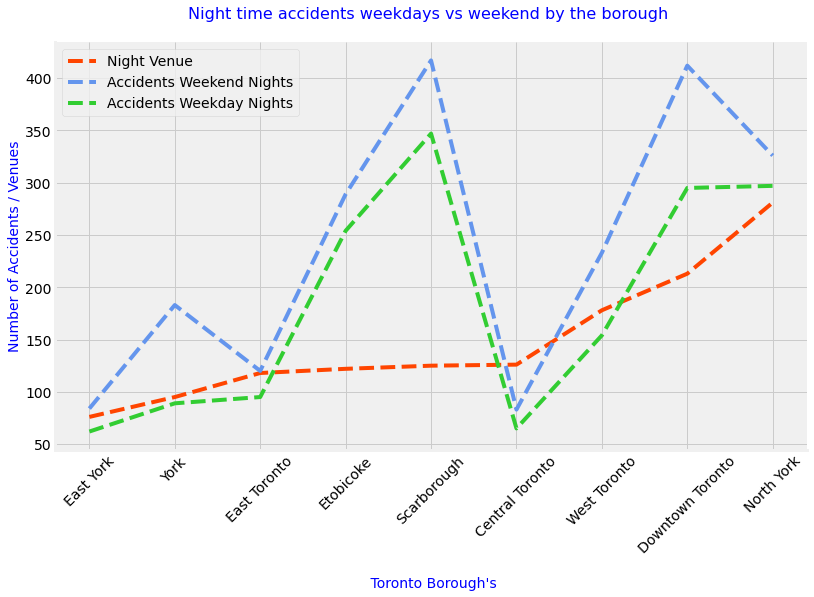

In [35]:
# Graph showing the comparision of accidents during week
labels = bdf.Borough.tolist()
x=np.arange(len(labels))

fig = plt.figure(figsize=(12,7),frameon=False) #frameon If False, suppress drawing the figure background patch.
ax = fig.add_subplot(111)

ax.spines["right"].set_visible(False)# border lines of the figure, except bottom one hiding the 3 others 
ax.spines["top"].set_visible(False)

# column list is names of df converted into a list above
ax.plot(bdf['Borough'],bdf['nightVenueCount'],linewidth=4.0, color='orangered',linestyle='dashed', label='Night Venue')
ax.plot(bdf['Borough'],bdf['accidentWeekend'],linewidth=4.0, color='cornflowerblue',linestyle='dashed', label='Accidents Weekend Nights')
ax.plot(bdf['Borough'],bdf['accidentWeekDays'],linewidth=4.0, color='limegreen',linestyle='dashed', label='Accidents Weekday Nights')

ax.xaxis.set_label_position('top')
ax.set_title("Night time accidents weekdays vs weekend by the borough \n", fontsize=16, color=labCol)
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=45,  fontsize=14) 
ax.set_ylabel('Number of Accidents / Venues', color=labCol,fontsize=14)

ax.xaxis.set_label_position('bottom')
ax.set_xlabel("\n Toronto Borough's",fontsize=14, color=labCol)
ax.legend(loc='upper left')

plt.show()

#### Toronto city is divided into 9 Boroughs.<br> Accident data by the boroughs indicate  accidents on weekend nights increases in the boroughs,<br> which has higher number of nigtlife spots.

## $\color{blue}{\textbf{5 - Modeling}}$
Exploratory data analysis indicates number of nightlife spots in a postal district increases accidents on weekend nights. <br> Lets run a unsupervised algorithm <strong> K-means </strong> to classify the postal districts.

### $\color{blue}{\textbf{5.1 - Standardized the Data using the Standard Scaler}}$
Before running the K-means algorithm, the numerical data needs to be standardized.

In [36]:
data = combine_df[['accidentWeekDays','accidentWeekend','nightVenueCount']].to_numpy()
# define standard scaler
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

### $\color{blue}{\textbf{5.2 - Determine Optimal Value for K}}$ 
Apply ELBOW method to find the optimal value for number of clusters.

In [37]:
distortions = []
K = range(1, 10)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(scaled)
	kmeanModel.fit(scaled)
	distortions.append(sum(np.min(cdist(scaled, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / scaled.shape[0])


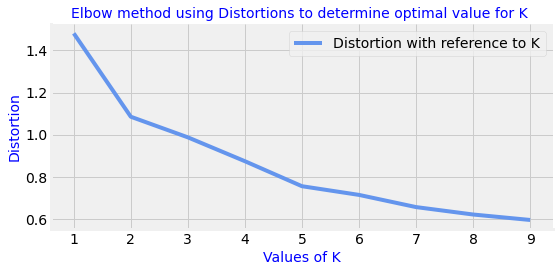

In [38]:
fig = plt.figure(figsize=(8,4),frameon=False) #frameon If False, suppress drawing the figure background patch.
ax = fig.add_subplot(111)

ax.spines["right"].set_visible(False)# border lines of the figure, except bottom one hiding the 3 others 
ax.spines["top"].set_visible(False)

# column list is names of df converted into a list above
ax.plot(K,distortions,linewidth=4.0, color='cornflowerblue',linestyle='solid', label='Distortion with reference to K')

ax.set_xlabel('Values of K',color=labCol,fontsize=14)
ax.set_ylabel('Distortion',color=labCol,fontsize=14)


ax.set_title("Elbow method using Distortions to determine optimal value for K ",color=labCol, fontsize=14)
ax.set_xticks(K)

ax.legend()
fig.tight_layout()
plt.show()

#### Elbow method indicate K =4 will be the optimal value.

### $\color{blue}{\textbf{5.3 - Run K Means Algorithm on the Data}}$
Data is standardized, and optimal value for K is 4 based on the Elbow meth. <br> Run the K-means unsupervised classification algorithm.

In [39]:
kclusters = 4 # set number of clusters, based on elbow method

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=20,max_iter=600,init='k-means++',random_state=0).fit(scaled)
# adding the labels generated by kmeans into combine_df at the very end
combine_df.insert(4, 'Cluster Labels', kmeans.labels_)
combine_df.head()

FSA  totalAccidents  accidentWeekend  accidentWeekDays  Cluster Labels  \
65  M5V             147               94                53               2   
71  M6H             115               70                45               2   
21  M2N              94               59                35               2   
42  M4M              98               52                46               2   
28  M3J              47               23                24               3   

    nightVenueCount   Latitude  Longitude           Borough  \
65               54  43.628947 -79.394420  Downtown Toronto   
71               42  43.669005 -79.442259      West Toronto   
21               42  43.770120 -79.408493        North York   
42               37  43.659526 -79.340923      East Toronto   
28               34  43.767980 -79.487262        North York   

                                         Neighborhood  
65  CN Tower, King and Spadina, Railway Lands, Har...  
71                       Dufferin, Dovercourt Village  
21                                   Willowdale South  
42                                    Studio District  
28                    Northwood Park, York University

## $\color{blue}{\textbf{6 - Results & Discussion}}$
K-means algorithm divided the postal districts of Toronto into four groups. <br>
The table & graph below summarized the results by cluster.


In [40]:
# sumarized data by cluster
df =combine_df.groupby(['Cluster Labels'],as_index=False).agg(
    Nightlife_Spots=('nightVenueCount','sum'), # sum off all the nightlife spot venues in the FSA
    Weekend_Accidents=('accidentWeekend','sum'), # sum of weekend accidents
    WeekDay_Accidents=('accidentWeekDays','sum'), # sum of weekdays accidents
    Total_FSA=('FSA','count')
)

# Add cluster to nightAccident_df and venues_df
nightAccident_df=pd.merge(nightAccident_df,combine_df[['FSA','Cluster Labels']],on='FSA')
venues_df=pd.merge(venues_df,combine_df[['FSA','Cluster Labels']],on='FSA')

# Calculating average number of FSA, accidents per cluster
x=pd.DataFrame(df.mean(axis=0)).transpose().round(decimals=0).astype(int)
df_avg=df.append(x,ignore_index=True)
df_avg.iloc[4,0]=9 # setting the cluster labels to 9 for average cluster
df_avg.head()

Cluster Labels  Nightlife_Spots  Weekend_Accidents  WeekDay_Accidents  \
0               0              524                754                692   
1               1              124                591                423   
2               2              207                330                211   
3               3              479                472                332   
4               9              334                537                414   

   Total_FSA  
0         60  
1         12  
2          5  
3         18  
4         24

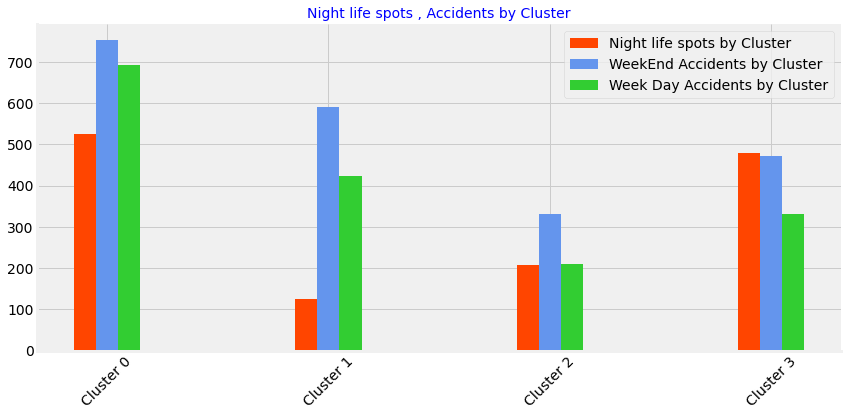

In [41]:
labels = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
x=np.arange(len(labels))
width = 0.1
fig = plt.figure(figsize=(12,6),frameon=False) #frameon If False, suppress drawing the figure background patch.
ax = fig.add_subplot(111)

ax.spines["right"].set_visible(False)# border lines of the figure, except bottom one hiding the 3 others 
ax.spines["top"].set_visible(False)

# column list is names of df converted into a list above
ax.bar(x-width,df['Nightlife_Spots'], width, color='orangered'  , label='Night life spots by Cluster') 
ax.bar(x,df['Weekend_Accidents'],width, color='cornflowerblue', label='WeekEnd Accidents by Cluster')
ax.bar(x+width,df['WeekDay_Accidents'],width, color='limegreen', label='Week Day Accidents by Cluster')

ax.xaxis.set_label_position('top')
ax.set_title("Night life spots , Accidents by Cluster", fontsize=14, color=labCol)
ax.set_xticks(x)
ax.set_xticklabels(labels,  fontsize=14,rotation=45) 
ax.legend()

fig.tight_layout()
plt.show()

#### The accidents on the weekend nights are more than regular weekday nights in all 4 clusters.

###  $\color{blue}{\textbf{6.1 Postal Districts by Clusters Map}}$
Maps shows how postal districts are clustered.<br>
The outer color is same for all postal districts.
<br> The number inside circle represent the cluster number.

In [42]:
# create folium , showing postal districts based on classification.
map_clusters = folium.Map(location=[43.7043244,-79.3887901], width=600, height=350, zoom_start=10) # toronto center
col_List=['red','green','blue','black']
title_html = '''
             <h3 align="left" style="color:#0000FF;font-size:20px"><b>&nbsp;&nbsp;&nbsp;&nbsp;Postal Districts by Cluster</b></h3><div style="text-align:left"><span style = "color:#0000FF;">&nbsp;&nbsp;Number inside the circle represent the cluster number</span></div> 
             '''
map_clusters.get_root().html.add_child(folium.Element(title_html))

# add markers to the map
for lat, lon, poi, cluster in zip(combine_df['Latitude'], combine_df['Longitude'], combine_df['FSA'], combine_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    p=str(lat)
    q=str(lon)
    icon_number = plugins.BeautifyIcon(
    border_color=col_List[cluster],
    text_color='#000000', #'#00ABDC',
    radius=10,
    number=int(cluster),
    inner_icon_style='margin-top:0;')
    
    folium.Marker(location=[lat, lon], popup=p+q, icon=icon_number).add_to(map_clusters)
       
map_clusters

In [48]:
def drawGraphs( clNum):
    mpl.style.use('fivethirtyeight')
    #mpl.style.use('ggplot')
    # seperate the data for cluster
    
    fig = plt.figure(figsize=(12,4))
    ax1=fig.add_subplot(1,1,1)
        
    labels = ['Night life Spots','Weekend Accidents','Weekday Accidents','Total FSA']
    x=np.arange(len(labels))

    
    ax1.spines["right"].set_visible(False)# border lines of the figure, except bottom one hiding the 3 others 
    ax1.spines["top"].set_visible(False)

    stitle="Cluster "+str(clNum)
    ax1.plot(df_avg.columns[1:].tolist(),df_avg.iloc[4,1:],linewidth=4.0, color='orangered',linestyle='dashed', label='Average')
    ax1.bar(x,df_avg.iloc[clNum,1:],0.11, color='cornflowerblue', label=stitle)

    ax1.xaxis.set_label_position('top')
    stitle=stitle+" Numbers vs Average Cluster \n"
    ax1.set_title(stitle, fontsize=16, color=labCol)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels,  fontsize=12,rotation=45) #,
    ax1.set_ylabel('Number of Accidents / Venues / FSA', color=labCol,fontsize=10)

    ax1.xaxis.set_label_position('bottom')
    ax1.legend(loc='upper right')

       
    plt.show()
   
    return


###  $\color{blue}{\textbf{Cluster 0 Results}}$

In [49]:
combine_df[combine_df['Cluster Labels'] ==0].head()

FSA  totalAccidents  accidentWeekend  accidentWeekDays  Cluster Labels  \
39  M4J              22               10                12               0   
46  M4S               8                7                 1               0   
48  M4V               2                2                 0               0   
51  M4Y              31               18                13               0   
60  M5M               2                0                 2               0   

    nightVenueCount   Latitude  Longitude           Borough  \
39               20  43.685347 -79.338106         East York   
46               19  43.704324 -79.388790   Central Toronto   
48               18  43.686412 -79.400049   Central Toronto   
51               17  43.665860 -79.383160  Downtown Toronto   
60               16  43.733283 -79.419750        North York   

                                         Neighborhood  
39                                 The Danforth  East  
46                                         Davisville  
48  Summerhill West, Rathnelly, South Hill, Forest...  
51                               Church and Wellesley  
60                  Bedford Park, Lawrence Manor East

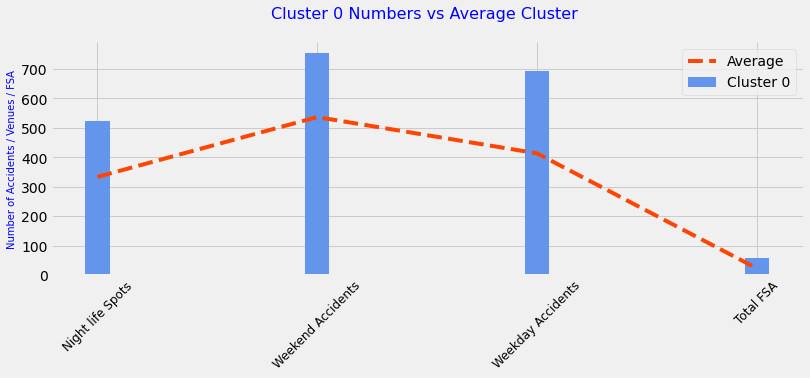

In [51]:
drawGraphs(0)

All numbers in Cluster 0 are more than average per cluster <br>
Highest number of Total accidents  across all clusters. The Weekend Accidents are more than Weekday Accidents.
Almost half of the FSAs are in cluster zero

###  $\color{blue}{\textbf{Cluster 1 Results}}$

In [52]:
combine_df[combine_df['Cluster Labels'] ==1].head()

FSA  totalAccidents  accidentWeekend  accidentWeekDays  Cluster Labels  \
52  M5A              91               47                44               1   
11  M1R              64               35                29               1   
76  M6N              83               57                26               1   
64  M5T              85               49                36               1   
10  M1P              80               37                43               1   

    nightVenueCount   Latitude  Longitude           Borough  \
52               18  43.654260 -79.360636  Downtown Toronto   
11               15  43.750071 -79.295849       Scarborough   
76               14  43.673185 -79.487262              York   
64               13  43.653206 -79.400049  Downtown Toronto   
10               13  43.757410 -79.273304       Scarborough   

                                         Neighborhood  
52                          Regent Park, Harbourfront  
11                                  Wexford, Maryvale  
76                      Runnymede, The Junction North  
64          Kensington Market, Chinatown, Grange Park  
10  Dorset Park, Wexford Heights, Scarborough Town...

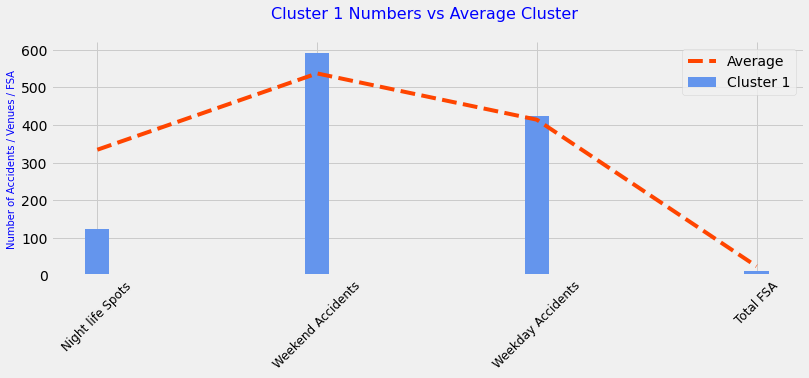

In [53]:
drawGraphs(1)

Cluster 1 relatively higher number of Night life spots. The Weekend Accidents  or Weekday Accidents both are less than average per cluster.<br> The Weekend Accidents are more than Weekday Accidents.  

###  $\color{blue}{\textbf{Cluster 2 Results}}$

In [54]:
combine_df[combine_df['Cluster Labels'] ==2].head()

FSA  totalAccidents  accidentWeekend  accidentWeekDays  Cluster Labels  \
65  M5V             147               94                53               2   
71  M6H             115               70                45               2   
21  M2N              94               59                35               2   
42  M4M              98               52                46               2   
35  M4C              87               55                32               2   

    nightVenueCount   Latitude  Longitude           Borough  \
65               54  43.628947 -79.394420  Downtown Toronto   
71               42  43.669005 -79.442259      West Toronto   
21               42  43.770120 -79.408493        North York   
42               37  43.659526 -79.340923      East Toronto   
35               32  43.695344 -79.318389         East York   

                                         Neighborhood  
65  CN Tower, King and Spadina, Railway Lands, Har...  
71                       Dufferin, Dovercourt Village  
21                                   Willowdale South  
42                                    Studio District  
35                                   Woodbine Heights

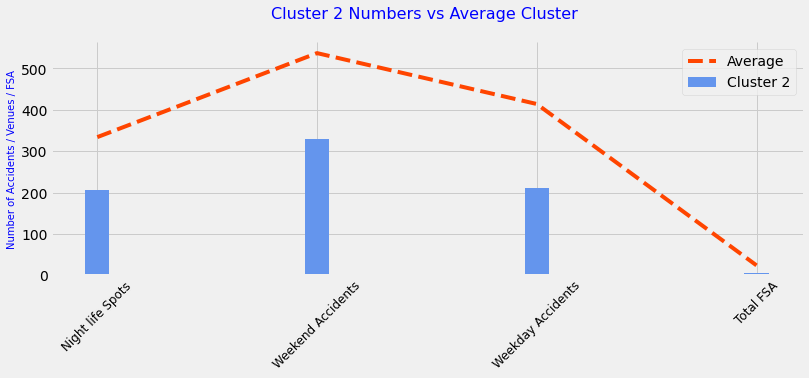

In [55]:
drawGraphs(2)

All numbers in cluster 2 are significantly less than average per cluster. Cluster 2 has smallest number of night life spots. <br> The weekend accidents are more than weekdays accidents.

###  $\color{blue}{\textbf{Cluster 3 Results}}$

In [56]:
combine_df[combine_df['Cluster Labels'] ==3].head()

FSA  totalAccidents  accidentWeekend  accidentWeekDays  Cluster Labels  \
28  M3J              47               23                24               3   
69  M6E              64               56                 8               3   
78  M6R              46               25                21               3   
36  M4E               9                4                 5               3   
72  M6J              57               40                17               3   

    nightVenueCount   Latitude  Longitude       Borough  \
28               34  43.767980 -79.487262    North York   
69               33  43.689026 -79.453512          York   
78               32  43.648960 -79.456325  West Toronto   
36               31  43.676357 -79.293031  East Toronto   
72               29  43.647927 -79.419750  West Toronto   

                       Neighborhood  
28  Northwood Park, York University  
69              Caledonia-Fairbanks  
78           Parkdale, Roncesvalles  
36                      The Beaches  
72         Little Portugal, Trinity

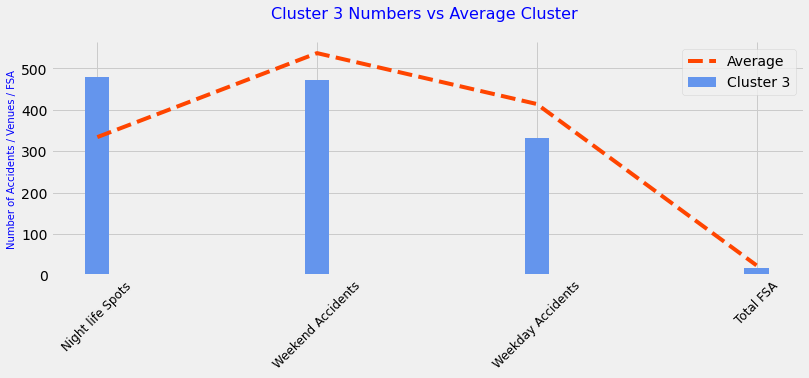

In [57]:
drawGraphs(3)

Cluster 3, relatively small number of night life spots. The Weekend Accidents , and Weekday Accidents are more than average.<br>
The Weekend Accidents are more than Weekday Accidents.